# PackedSelection in Coffea 2023

In `coffea`, `PackedSelection` is a class that can store several boolean arrays in a memory-efficient manner and evaluate arbitrary combinations of boolean requirements in an CPU-efficient way. Supported inputs include 1D numpy or awkward arrays and it has built-in functionalities to form analysis in signal and control regions, and to implement cutflow or "N-1" plots.

Although `coffea` 2023 should be used in delayed mode (using `dask-awkward`), we will first present these functionalities eagerly (like in `coffea` 0.7) to showcase this better. Let's first read a sample file of 40 Drell-Yan events to demonstrate the utilities using our `NanoAODSchema` as our schema.

In [1]:
import awkward as ak
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from matplotlib import pyplot as plt

fname = "https://raw.githubusercontent.com/scikit-hep/coffea/master/tests/samples/nano_dy.root"
events = NanoEventsFactory.from_root(
    {fname: "Events"},
    metadata={"dataset": "nano_dy"},
    schemaclass=NanoAODSchema,
    delayed=False,
).events()

events

/Users/nmangane/scikit-hep-dev-2/coffea/src/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector
/Users/nmangane/scikit-hep-dev-2/coffea/src/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/Users/nmangane/scikit-hep-dev-2/coffea/src/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross

<NanoEventsArray [<event 1:                13889:                3749778>, ...] type='...'>

Now let's import `PackedSelection`, and create an instance of it.

In [2]:
from coffea.analysis_tools import PackedSelection

selection = PackedSelection()

We can create a boolean mask and add this to our selection by using the `add` method. This adds the following "cut" to our selection and names it "twoElectron".

In [3]:
selection.add("twoElectron", ak.num(events.Electron) == 2)

We've added one "cut" to our selection. Now let's add a couple more.

In [4]:
selection.add("eleOppSign", ak.sum(events.Electron.charge, axis=1) == 0)
selection.add("noElectron", ak.num(events.Electron) == 0)

To avoid repeating calling `add` multiple times, we can just use the `add_multiple` method which does just that.

In [5]:
selection.add_multiple(
    {
        "twoMuon": ak.num(events.Muon) == 2,
        "muOppSign": ak.sum(events.Muon.charge, axis=1) == 0,
        "noMuon": ak.num(events.Muon) == 0,
        "leadPt20": ak.any(events.Electron.pt >= 20.0, axis=1)
        | ak.any(events.Muon.pt >= 20.0, axis=1),
    }
)

By viewing the `PackedSelection` instance, one can see the names of the added selections, whether it is operating in delayed mode or not, the number of added selections and the maximum supported number of selections.

In [6]:
print(selection)

PackedSelection(selections=('twoElectron', 'eleOppSign', 'noElectron', 'twoMuon', 'muOppSign', 'noMuon', 'leadPt20'), delayed_mode=False, items=7, maxitems=32)


To evaluate a boolean mask (e.g. to filter events) we can use the `selection.all(*names)` function, which will compute the logical AND of all listed boolean selections.

In [7]:
selection.all("twoElectron", "noMuon", "leadPt20")

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

We can also be more specific and require that a specific set of selections have a given value (with the unspecified ones allowed to be either true or false) using `selection.require`.

In [8]:
selection.require(twoElectron=True, noMuon=True, eleOppSign=False)

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

There exist also the `allfalse` and `any` methods where the first one is the opposite of `all` and the second one is a logical OR between all listed boolean selections.

Using `PackedSelection`, we are now able to perform an N-1 style selection using the `nminusone(*names)` method. This will perform an N-1 style selection by using as "N" the provided names and will exclude each named cut one at a time in order. In the end it will also peform a selection using all N cuts.

In [9]:
nminusone = selection.nminusone("twoElectron", "noMuon", "leadPt20")
nminusone

NminusOne(selections=('twoElectron', 'noMuon', 'leadPt20'))

This returns an `NminusOne` object which has the following methods: `result()`, `print()`, `yieldhist()`, `to_npz()` and `plot_vars()`

Let's look at the results of the N-1 selection.

In [10]:
res = nminusone.result()
print(type(res), res._fields)

<class 'coffea.analysis_tools.NminusOneResult'> ('labels', 'nev', 'masks')


This is just a `namedtuple` with the attributes `labels`, `nev` and `masks`. So we can say:

In [11]:
labels, nev, masks = res
labels, nev, masks

(['initial', 'N - twoElectron', 'N - noMuon', 'N - leadPt20', 'N'],
 [40, np.int64(10), np.int64(3), np.int64(5), np.int64(3)],
 [array([False,  True,  True, False, False, False, False, False, False,
          True, False, False, False, False, False,  True,  True, False,
         False, False,  True,  True, False, False, False, False, False,
          True, False,  True, False, False, False,  True, False, False,
         False, False, False, False]),
  array([False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False]),
  array([False, False,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
          True, False,  True,  True, False, False, False, False, False,
  

`labels` is a list of labels of each mask that is applied, `nev` is a list of the number of events that survive each mask, and `masks` is a list of boolean masks (arrays) of which events survive each selection.
You can also choose to print the statistics of your N-1 selection in a similar fashion to `RDataFrame`.

In [12]:
nminusone.print()

N-1 selection stats:
Ignoring twoElectron         pass = 10                  all = 40                  -- eff = 25.0 %
Ignoring noMuon              pass = 3                   all = 40                  -- eff = 7.5 %
Ignoring leadPt20            pass = 5                   all = 40                  -- eff = 12.5 %
All cuts                     pass = 3                   all = 40                  -- eff = 7.5 %


Or get a histogram of your total event yields. This just returns a `hist.Hist` object and we can plot it with its backends to `mplhep`.

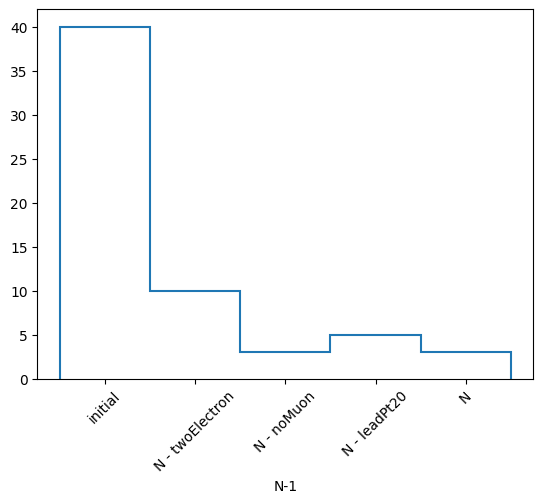

In [13]:
h, labels = nminusone.yieldhist()
h.plot1d()
plt.xticks(plt.gca().get_xticks(), labels, rotation=45)
plt.show()

You can also save the results of the N-1 selection to a `.npz` file for later use.

In [14]:
nminusone.to_npz("nminusone_results.npz").compute()
with np.load("nminusone_results.npz") as f:
    for i in f.files:
        print(f"{i}: {f[i]}")

labels: ['initial' 'N - twoElectron' 'N - noMuon' 'N - leadPt20' 'N']
nev: [40 10  3  5  3]
masks: [[False  True  True False False False False False False  True False False
  False False False  True  True False False False  True  True False False
  False False False  True False  True False False False  True False False
  False False False False]
 [False False  True False False False False False False False False False
  False False False False False False False False  True  True False False
  False False False False False False False False False False False False
  False False False False]
 [False False  True  True False False False False False False False False
  False False False False False False  True False  True  True False False
  False False False False False False False False False False False False
  False False False False]
 [False False  True False False False False False False False False False
  False False False False False False False False  True  True False False
  Fals

Finally, we can ask from this object to create histograms of different variables, masking them with our N-1 selection.
What it will output is a list of histograms, one for each requested variable, where the x-axis is the distribution of the variable, and the y-axis is the mask that was applied.
It is essentially slices of how the variable distribution evolves as each N-1 or N selection is applied. It does also return a list of labels of the masks to keep track.

Note that the variables are parsed using a dictonary of `name: array` pairs and that the arrays will of course be flattened to be histogrammed.

In [15]:
hs, labels = nminusone.plot_vars(
    {"Ept": events.Electron.pt, "Ephi": events.Electron.phi}
)
hs, labels

([Hist(
    Regular(20, 5.81891, 60.0685, name='Ept'),
    Integer(0, 5, name='N-1'),
    storage=Double()) # Sum: 55.0 (60.0 with flow),
  Hist(
    Regular(20, -2.93115, 3.11865, name='Ephi'),
    Integer(0, 5, name='N-1'),
    storage=Double()) # Sum: 60.0],
 ['initial', 'N - twoElectron', 'N - noMuon', 'N - leadPt20', 'N'])

And we can actually plot those histograms using again the `mplhep` backend.

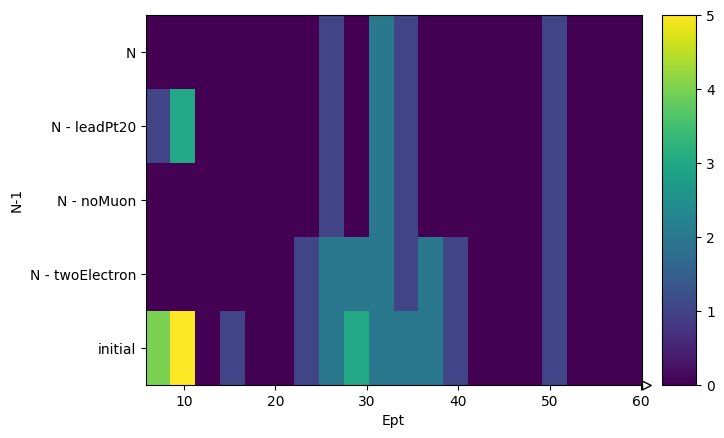

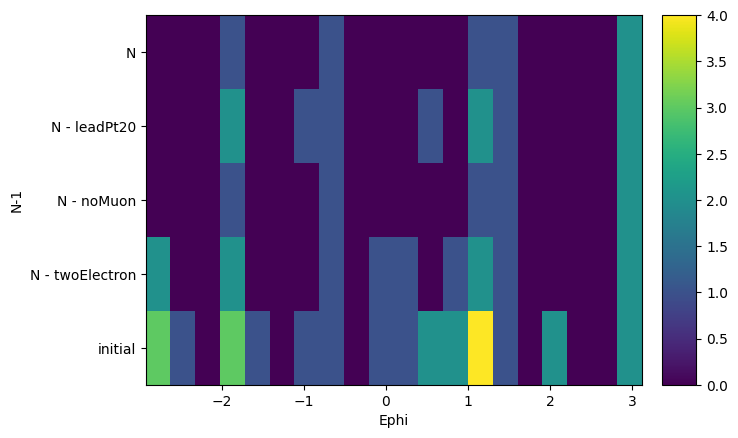

In [16]:
for h in hs:
    h.plot2d()
    plt.yticks(plt.gca().get_yticks(), labels, rotation=0)
    plt.show()

You can slice these histograms to view and plot the 1D histogram at each step of the selection. For example, if we want the $P_T$ of the electrons at the final step (index 4) of the selection, we can do the following.

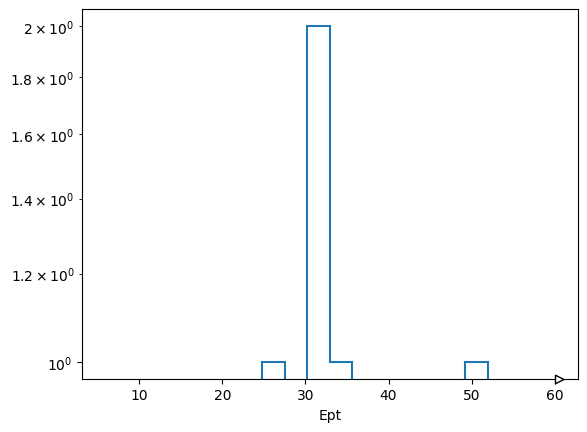

In [17]:
hs[0][:, 4].plot1d(yerr=0)
plt.yscale("log")
plt.show()

Because this automatic bining doesn't look great, for $P_T$ at least, the user has the ability to customize the axes or pass in their own axes objects.

In [18]:
help(nminusone.plot_vars)

Help on method plot_vars in module coffea.analysis_tools:

plot_vars(vars, axes=None, bins=None, start=None, stop=None, edges=None, transform=None) method of coffea.analysis_tools.NminusOne instance
    Plot the histograms of variables for each step of the N-1 selection

    Parameters
    ----------
        vars : dict
            A dictionary in the form ``{name: array}`` where ``name`` is the name of the variable,
            and ``array`` is the corresponding array of values.
            The arrays must be the same length as each mask of the N-1 selection.
        axes : list of hist.axis objects, optional
            The axes objects to histogram the variables on. This will override all the following arguments that define axes.
            Must be the same length as ``vars``.
        bins : iterable of integers or Nones, optional
            The number of bins for each variable histogram. If not specified, it defaults to 20.
            Must be the same length as ``vars``.
       

Cutflow is implemented in a similar manner to the N-1 selection. We just have to use the `cutflow(*names)` function which will return a `Cutflow` object

In [19]:
cutflow = selection.cutflow("noMuon", "twoElectron", "leadPt20")
cutflow

Cutflow(selections=('noMuon', 'twoElectron', 'leadPt20'), commonmasked=False, weighted=False, weightsmodifier=None)

The methods of this object are similar to the `NminusOne` object. The only difference is that now we seperate things in either "onecut" or "cutflow". "onecut" represents results where each cut is applied alone, while "cutflow" represents results where the cuts are applied cumulatively in order.

In [20]:
res = cutflow.result()
print(type(res), res._fields)
labels, nevonecut, nevcutflow, masksonecut, maskscutflow = res
labels, nevonecut, nevcutflow, masksonecut, maskscutflow

<class 'coffea.analysis_tools.CutflowResult'> ('labels', 'nevonecut', 'nevcutflow', 'masksonecut', 'maskscutflow')


(['initial', 'noMuon', 'twoElectron', 'leadPt20'],
 [40, np.int64(28), np.int64(5), np.int64(17)],
 [40, np.int64(28), np.int64(5), np.int64(3)],
 [array([ True,  True,  True,  True, False, False, False,  True,  True,
          True, False,  True,  True,  True, False,  True,  True,  True,
          True,  True,  True,  True,  True, False, False,  True, False,
          True, False,  True, False, False,  True,  True, False,  True,
          True,  True,  True,  True]),
  array([False, False,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
          True, False,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False]),
  array([False,  True,  True, False,  True,  True,  True, False, False,
          True, False, False, False, False, False,  True,  True, False,
         False, False,  True,  True, False,  True,  True

As you can see, again we have the same `labels`, `nev` and `masks` only now we have two "versions" of them since they've been split into "onecut" and "cutflow".
You can again print the statistics of the cutflow exactly like `RDataFrame`.

In [21]:
cutflow.print()

Cutflow stats:
Cut noMuon              :pass = 28                  cumulative pass = 28                  all = 40                  -- eff = 70.0 %                    -- cumulative eff = 70.0 %
Cut twoElectron         :pass = 5                   cumulative pass = 5                   all = 40                  -- eff = 12.5 %                    -- cumulative eff = 12.5 %
Cut leadPt20            :pass = 17                  cumulative pass = 3                   all = 40                  -- eff = 42.5 %                    -- cumulative eff = 7.5 %


Again, you can extract yield hists, only now there are two of them.

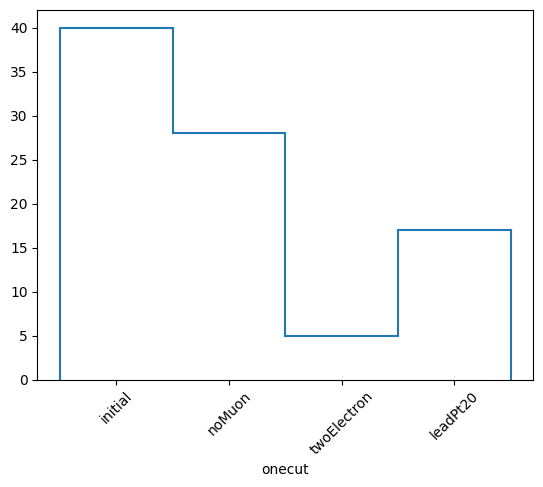

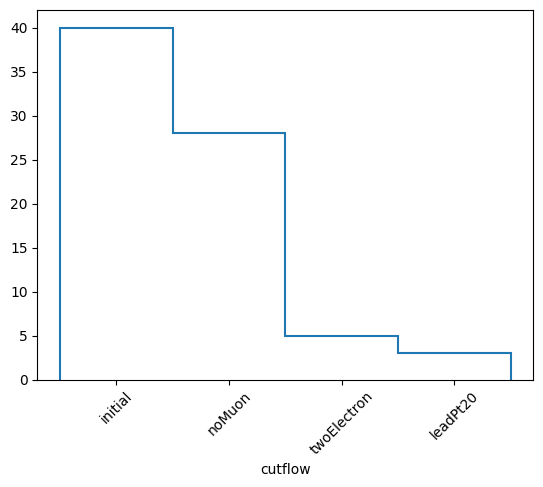

In [22]:
honecut, hcutflow, labels = cutflow.yieldhist()

honecut.plot1d(yerr=0)
plt.xticks(plt.gca().get_xticks(), labels, rotation=45)
plt.show()

hcutflow.plot1d(yerr=0)
plt.xticks(plt.gca().get_xticks(), labels, rotation=45)
plt.show()

Saving to `.npz` files is again there.

In [23]:
cutflow.to_npz("cutflow_results.npz").compute()

with np.load("cutflow_results.npz") as f:
    for i in f.files:
        print(f"{i}: {f[i]}")

labels: ['initial' 'noMuon' 'twoElectron' 'leadPt20']
nevonecut: [40 28  5 17]
nevcutflow: [40 28  5  3]
masksonecut: [[ True  True  True  True False False False  True  True  True False  True
   True  True False  True  True  True  True  True  True  True  True False
  False  True False  True False  True False False  True  True False  True
   True  True  True  True]
 [False False  True  True False False False False False False False False
  False False False False False False  True False  True  True False False
  False False False False False False False False False False False False
  False False False False]
 [False  True  True False  True  True  True False False  True False False
  False False False  True  True False False False  True  True False  True
   True False  True  True False  True False  True False  True False False
  False False False False]]
maskscutflow: [[ True  True  True  True False False False  True  True  True False  True
   True  True False  True  True  True  True  T

And finally, `plot_vars` is also there with the same axes customizability while now it returns two lists of histograms, one for "onecut" and one for "cutflow". Those can of course be plotted in a similar fashion.

In [24]:
h1, h2, labels = cutflow.plot_vars(
    {"ept": events.Electron.pt, "ephi": events.Electron.phi}
)
h1, h2, labels

([Hist(
    Regular(20, 5.81891, 60.0685, name='ept'),
    Integer(0, 4, name='onecut'),
    storage=Double()) # Sum: 69.0 (73.0 with flow),
  Hist(
    Regular(20, -2.93115, 3.11865, name='ephi'),
    Integer(0, 4, name='onecut'),
    storage=Double()) # Sum: 73.0],
 [Hist(
    Regular(20, 5.81891, 60.0685, name='ept'),
    Integer(0, 4, name='cutflow'),
    storage=Double()) # Sum: 59.0 (63.0 with flow),
  Hist(
    Regular(20, -2.93115, 3.11865, name='ephi'),
    Integer(0, 4, name='cutflow'),
    storage=Double()) # Sum: 63.0],
 ['initial', 'noMuon', 'twoElectron', 'leadPt20'])

# Weighted Cutflows
It's also possible to apply per-event weights to a cutflow by passing in a Weights instance, along with the `weightsmodifier` (None or the string name of the variation you want applied)

In [25]:
from coffea.analysis_tools import Weights

weights = Weights(len(events))
weights.add("genweight", events.genWeight)

wgtcutflow = selection.cutflow("noMuon", "twoElectron", "leadPt20", weights=weights, weightsmodifier=None)
wgtcutflow

Cutflow(selections=('noMuon', 'twoElectron', 'leadPt20'), commonmasked=False, weighted=True, weightsmodifier=None)

In [26]:
res = wgtcutflow.result()
print(type(res), res._fields)
(labels, nevonecut, nevcutflow, 
 masksonecut, maskscutflow, 
 commonmask, 
 wgtevonecut, wgtevcutflow,
 rweights,rmod
) = res
labels, nevonecut, nevcutflow, masksonecut, maskscutflow, commonmask, wgtevonecut, wgtevcutflow, rweights,rmod

<class 'coffea.analysis_tools.ExtendedCutflowResult'> ('labels', 'nevonecut', 'nevcutflow', 'masksonecut', 'maskscutflow', 'commonmask', 'wgtevonecut', 'wgtevcutflow', 'weights', 'weightsmodifier')


(['initial', 'noMuon', 'twoElectron', 'leadPt20'],
 [40, np.int64(28), np.int64(5), np.int64(17)],
 [40, np.int64(28), np.int64(5), np.int64(3)],
 [array([ True,  True,  True,  True, False, False, False,  True,  True,
          True, False,  True,  True,  True, False,  True,  True,  True,
          True,  True,  True,  True,  True, False, False,  True, False,
          True, False,  True, False, False,  True,  True, False,  True,
          True,  True,  True,  True]),
  array([False, False,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
          True, False,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False]),
  array([False,  True,  True, False,  True,  True,  True, False, False,
          True, False, False, False, False, False,  True,  True, False,
         False, False,  True,  True, False,  True,  True

The weighted cutflow by default prints with weights if included, but passing `weighted=False` or `weighted=True` allows one to explicitly toggle between the two. Additionally, the keyword `scale` permits one to scale all value uniformly, such as with a cross-section, luminosity, sum of weights, etc.

In [27]:
wgtcutflow.print()

Cutflow stats: (weighted)
Cut noMuon              :pass = 315450.423828125    cumulative pass = 315450.423828125    all = 578762.435546875    -- eff = 54.5 %                    -- cumulative eff = 54.5 %
Cut twoElectron         :pass = 25807.2109375       cumulative pass = 25807.2109375       all = 578762.435546875    -- eff = 4.5 %                    -- cumulative eff = 4.5 %
Cut leadPt20            :pass = 237244.12109375     cumulative pass = 26331.201171875     all = 578762.435546875    -- eff = 41.0 %                    -- cumulative eff = 4.5 %


In [28]:
wgtcutflow.print(weighted=False)

Cutflow stats:
Cut noMuon              :pass = 28                  cumulative pass = 28                  all = 40                  -- eff = 70.0 %                    -- cumulative eff = 70.0 %
Cut twoElectron         :pass = 5                   cumulative pass = 5                   all = 40                  -- eff = 12.5 %                    -- cumulative eff = 12.5 %
Cut leadPt20            :pass = 17                  cumulative pass = 3                   all = 40                  -- eff = 42.5 %                    -- cumulative eff = 7.5 %


In [29]:
wgtcutflow.print(weighted=True, scale=500/578762)

Cutflow stats: (weighted) (scaled by 0.0008639129728627657)
Cut noMuon              :pass = 272.5217134401749   cumulative pass = 272.5217134401749   all = 500.0003762745956   -- eff = 54.5 %                    -- cumulative eff = 54.5 %
Cut twoElectron         :pass = 22.295184322312107  cumulative pass = 22.295184322312107  all = 500.0003762745956   -- eff = 4.5 %                    -- cumulative eff = 4.5 %
Cut leadPt20            :pass = 204.95827394831554  cumulative pass = 22.74786628344207   all = 500.0003762745956   -- eff = 41.0 %                    -- cumulative eff = 4.5 %


The histograms are now by default weighted, but like the print function this can be explicitly toggled between using `weighted=True|False.`There's no option to scale the histograms by a scalar, this is left to a user to do so afterwards.

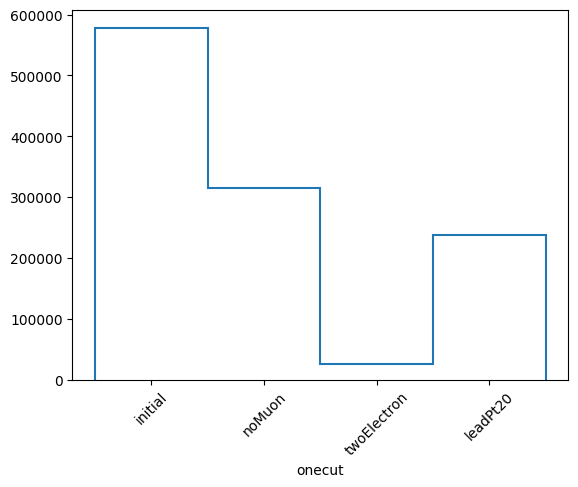

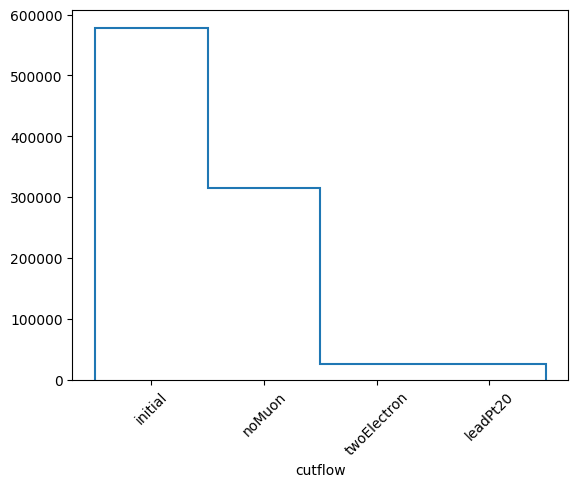

In [30]:
whonecut, whcutflow, wlabels = wgtcutflow.yieldhist()

whonecut.plot1d(yerr=0)
plt.xticks(plt.gca().get_xticks(), wlabels, rotation=45)
plt.show()

whcutflow.plot1d(yerr=0)
plt.xticks(plt.gca().get_xticks(), wlabels, rotation=45)
plt.show()

Saving to npz will include the weighted summary statistics by default, as well as a `commonmask`, but the actual weights (with the appropriate `weightsmodifier`) can also be saved directly, for later inspection.

In [31]:
npz = wgtcutflow.to_npz("cutflow_results_weighted.npz", includeweights=True)
print(npz)
npz.compute()

CutflowToNpz(file=cutflow_results_weighted.npz), labels=['initial', 'noMuon', 'twoElectron', 'leadPt20'], commonmasked=False, weighted=True, weightsmodifier=None)


In [32]:
with np.load("cutflow_results_weighted.npz") as f2:
    for i in f2.files:
        print(f"{i}: {f2[i]}")

labels: ['initial' 'noMuon' 'twoElectron' 'leadPt20']
nevonecut: [40 28  5 17]
nevcutflow: [40 28  5  3]
masksonecut: [[ True  True  True  True False False False  True  True  True False  True
   True  True False  True  True  True  True  True  True  True  True False
  False  True False  True False  True False False  True  True False  True
   True  True  True  True]
 [False False  True  True False False False False False False False False
  False False False False False False  True False  True  True False False
  False False False False False False False False False False False False
  False False False False]
 [False  True  True False  True  True  True False False  True False False
  False False False  True  True False False False  True  True False  True
   True False  True  True False  True False  True False  True False False
  False False False False]]
maskscutflow: [[ True  True  True  True False False False  True  True  True False  True
   True  True False  True  True  True  True  T

# Commonmask support in cutflow
The `commonmask` feature allows one to specify a boolean array that is applied to every individual and combination of cuts, as well as the initial counts. Orthogonal selections like a cut for channels or gen-level requirements can be specified independant of cuts applied to all channels, e.g. cuts on jet multiplicity or invariant masses, while allowing studies in individual 'channels.' This serves two purposes, one permitting the same studies with fewer masks in the PackedSelection (which in a very complex analysis might not fit into the widest storage backend) or even injecting 'external' boolean arrays, and two, allowing the single cuts and cutflows to be interpreted from more complex initial states than all events in a sample.

In [33]:
selection.add_multiple(
    {
        "lheTaus": ak.sum(np.abs(events.LHEPart.pdgId) == 15, axis=1) >= 2,
        "lheMuons": ak.sum(np.abs(events.LHEPart.pdgId) == 13, axis=1) >= 2,
        "lheElectrons": ak.sum(np.abs(events.LHEPart.pdgId) == 11, axis=1) >= 2,
    }
)

In [34]:

taucutflow = selection.cutflow("noMuon", "twoElectron", "leadPt20", commonmask=selection.require(lheTaus=True))
elecutflow = selection.cutflow("noMuon", "twoElectron", "leadPt20", commonmask=selection.require(lheElectrons=True))

In [35]:
print("TAUS")
taucutflow.print()
print("ELECTRONS")
elecutflow.print()

TAUS
Cutflow stats:
Cut noMuon              :pass = 12                  cumulative pass = 12                  all = 18                  -- eff = 66.7 %                    -- cumulative eff = 66.7 %
Cut twoElectron         :pass = 2                   cumulative pass = 2                   all = 18                  -- eff = 11.1 %                    -- cumulative eff = 11.1 %
Cut leadPt20            :pass = 3                   cumulative pass = 0                   all = 18                  -- eff = 16.7 %                    -- cumulative eff = 0.0 %
ELECTRONS
Cutflow stats:
Cut noMuon              :pass = 13                  cumulative pass = 13                  all = 13                  -- eff = 100.0 %                    -- cumulative eff = 100.0 %
Cut twoElectron         :pass = 3                   cumulative pass = 3                   all = 13                  -- eff = 23.1 %                    -- cumulative eff = 23.1 %
Cut leadPt20            :pass = 9                   cumulative p

# Categorical Axis fill for `yieldhist` and `plot_vars`
In order to support subdividing a sample into subsamples or different channels in an efficient manner, a complex input `categorical` is available. This is expected to be a dictionary with several key-value pairs: `axis`: a `hist.axis` type including the axis features desired; `values`: an event-by-event array of fill values that should be passed into the histogram fill, and `labels`: the human-readable bin labels matching the axis passed in.

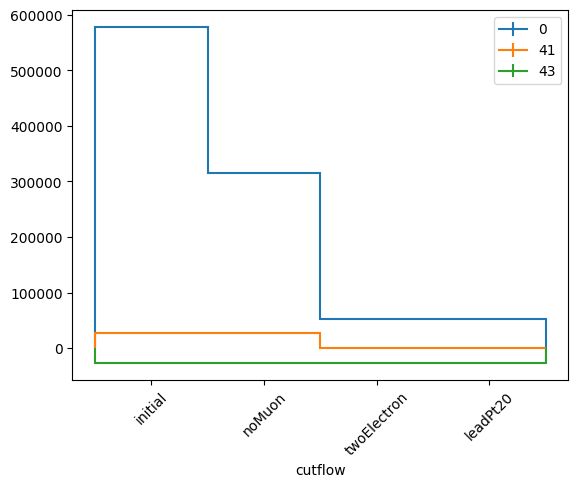

In [36]:
import hist
cwhonecut, cwhcutflow, cutlabels, catlabels = wgtcutflow.yieldhist(categorical={
    "axis": hist.axis.IntCategory([0, 41, 43], name="ttbarID"),
    "values": events.genTtbarId,
    "labels": ["X+jj", "X+c", "X+cc"]
})

cwhcutflow.plot1d(yerr=0, overlay="ttbarID")
plt.xticks(plt.gca().get_xticks(), wlabels, rotation=45)
plt.legend()
plt.show()

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x13fbbd6d0>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x1485b1160>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x13e859dc0>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x1485b2060>, errorbar=None, legend_artist=None)]

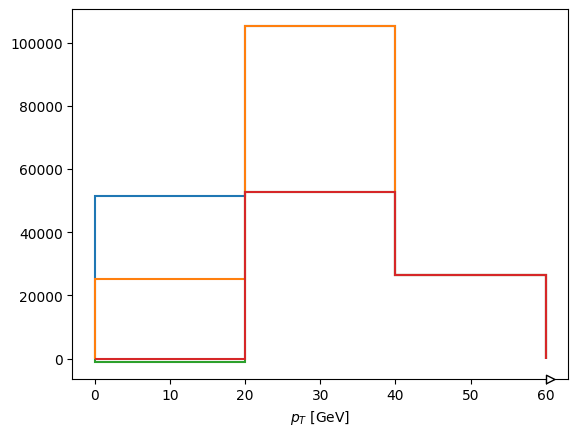

In [37]:
wch1, wch2, wclabels, catlabels = wgtcutflow.plot_vars(
    {"ept": events.Electron.pt, "ephi": events.Electron.phi},
    axes=[hist.axis.Regular(3, 0, 60, name="ept", label=r"$p_{T}$ [GeV]"), 
          hist.axis.Regular(10, -3.14, 3.14, name="ephi", label=r"$\phi", circular=True)],
    categorical={
        "axis": hist.axis.IntCategory([0, 41, 43], name="ttbarID"),
        "values": events.genTtbarId,
        "labels": ["X+jj", "X+c", "X+cc"]
    }
)
wch2[0][:, :, 0].project("ept", "cutflow").plot1d(overlay="cutflow", yerr=False)

Now, in `coffea` 2023, everything happens in a delayed fashion. Therefore, `PackedSelection` can also operate in delayed or lazy mode and fully support `dask_awkward` arrays. Use is still the same, but everything now is
a delayed `dask` type object which can be computed whenever the user wants to. This can be done by either calling `.compute()` on the object or `dask.compute(*things)`.

PackedSelection can be initialized to operate in delayed mode by adding a delayed `dask_awkward` array for the first time instead of a materialized `numpy` or `awkward` one.
I would like to note that we only support delayed `dask_awkward` arrays and not `dask.array` arrays. Please convert your `dask` arrays to `dask_awkward` via `dask_awkward.from_dask_array(array)`. I would also like to note that you cannot mix materialized and delayed arrays in the same `PackedSelection`. Let's now read the same events using dask and perform the exact same things.

In [38]:
import dask
import dask_awkward as dak

fname = "https://raw.githubusercontent.com/scikit-hep/coffea/master/tests/samples/nano_dy.root"
dakevents = NanoEventsFactory.from_root(
    {fname: "Events"},
    metadata={"dataset": "nano_dy"},
    schemaclass=NanoAODSchema,
    delayed=True,
).events()

dakevents

/Users/nmangane/scikit-hep-dev-2/coffea/src/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/Users/nmangane/scikit-hep-dev-2/coffea/src/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_genPartIdx => GenPart
  warnings.warn(
/Users/nmangane/scikit-hep-dev-2/coffea/src/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/Users/nmangane/scikit-hep-dev-2/coffea/src/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(


dask.awkward<from-uproot, npartitions=1>

Now `dakevents` is a delayed `dask_awkward` version of our events and if we compute it we get our normal events.

In [39]:
dakevents.compute()

<NanoEventsArray [<event 1:                13889:                3749778>, ...] type='...'>

Now we have to use `dask_awkward` instead of `awkward` and `dakevents` instead of `events` to do the same things. Let's add the same (now delayed) arrays to PackedSelection.

In [40]:
selection = PackedSelection()

selection.add_multiple(
    {
        "twoElectron": dak.num(dakevents.Electron) == 2,
        "eleOppSign": dak.sum(dakevents.Electron.charge, axis=1) == 0,
        "noElectron": dak.num(dakevents.Electron) == 0,
        "twoMuon": dak.num(dakevents.Muon) == 2,
        "muOppSign": dak.sum(dakevents.Muon.charge, axis=1) == 0,
        "noMuon": dak.num(dakevents.Muon) == 0,
        "leadPt20": dak.any(dakevents.Electron.pt >= 20.0, axis=1)
        | dak.any(dakevents.Muon.pt >= 20.0, axis=1),
    }
)

print(selection)

PackedSelection(selections=('twoElectron', 'eleOppSign', 'noElectron', 'twoMuon', 'muOppSign', 'noMuon', 'leadPt20'), delayed_mode=True, items=7, maxitems=32)


Now, the same functions will return `dask_awkward` objects that have to be computed.

In [41]:
selection.all("twoElectron", "noMuon", "leadPt20")

dask.awkward<equal, npartitions=1>

When computing those arrays we should get the same arrays that we got when operating in eager mode.

In [42]:
print(selection.all("twoElectron", "noMuon", "leadPt20").compute())
print(selection.require(twoElectron=True, noMuon=True, eleOppSign=False).compute())

[False, False, True, False, False, ..., False, False, False, False, False]
[False, False, False, True, False, ..., False, False, False, False, False]


Now, N-1 and cutflow will just return only delayed objects that must be computed.

In [43]:
nminusone = selection.nminusone("twoElectron", "noMuon", "leadPt20")
nminusone

NminusOne(selections=('twoElectron', 'noMuon', 'leadPt20'))

It is again an `NminusOne` object which has the same methods.

Let's look at the results of the N-1 selection in the same way

In [44]:
labels, nev, masks = nminusone.result()
labels, nev, masks

(['initial', 'N - twoElectron', 'N - noMuon', 'N - leadPt20', 'N'],
 [dask.awkward<count, type=Scalar, dtype=int64>,
  dask.awkward<sum, type=Scalar, dtype=int64>,
  dask.awkward<sum, type=Scalar, dtype=int64>,
  dask.awkward<sum, type=Scalar, dtype=int64>,
  dask.awkward<sum, type=Scalar, dtype=int64>],
 [dask.awkward<equal, npartitions=1>,
  dask.awkward<equal, npartitions=1>,
  dask.awkward<equal, npartitions=1>,
  dask.awkward<equal, npartitions=1>])

Now however, you can see that everything is a dask awkward object (apart from the labels of course). If we compute them we should get the same things as before and indeed we do:

In [45]:
dask.compute(*nev), dask.compute(*masks)

((np.int64(40), np.int64(10), np.int64(3), np.int64(5), np.int64(3)),
 (<Array [False, True, True, False, ..., False, False, False] type='40 * bool'>,
  <Array [False, False, True, False, ..., False, False, False] type='40 * bool'>,
  <Array [False, False, True, True, ..., False, False, False] type='40 * bool'>,
  <Array [False, False, True, False, ..., False, False, False] type='40 * bool'>))

We can again print the statistics, however for this to happen, the object must of course compute the delayed `nev` list.

In [46]:
nminusone.print()

/Users/nmangane/scikit-hep-dev-2/coffea/src/coffea/analysis_tools.py:825: UserWarning: Printing the N-1 selection statistics is going to compute dask_awkward objects.
  warnings.warn(


N-1 selection stats:
Ignoring twoElectron         pass = 10                  all = 40                  -- eff = 25.0 %
Ignoring noMuon              pass = 3                   all = 40                  -- eff = 7.5 %
Ignoring leadPt20            pass = 5                   all = 40                  -- eff = 12.5 %
All cuts                     pass = 3                   all = 40                  -- eff = 7.5 %


And now if we call `result()` again, the `nev` list is materialized.

In [47]:
nminusone.result().nev

[np.int64(40), np.int64(10), np.int64(3), np.int64(5), np.int64(3)]

Again the histogram of your total event yields works. This time it is returns a `hist.dask.Hist` object.

In [48]:
h, labels = nminusone.yieldhist()
h

Hist(Integer(0, 5, name='N-1'), storage=Double()) # (has staged fills)

It appears empty because it hasn't been computed yet. Let's do that.

In [49]:
h.compute()

Hist(Integer(0, 5, name='N-1'), storage=Double()) # Sum: 61.0

Notice that this doesn't happen in place as `h` is still not computed.

In [50]:
h

Hist(Integer(0, 5, name='N-1'), storage=Double())

We can again plot this histogram but we have to call plot on the computed one, otherwise it will just be empty.

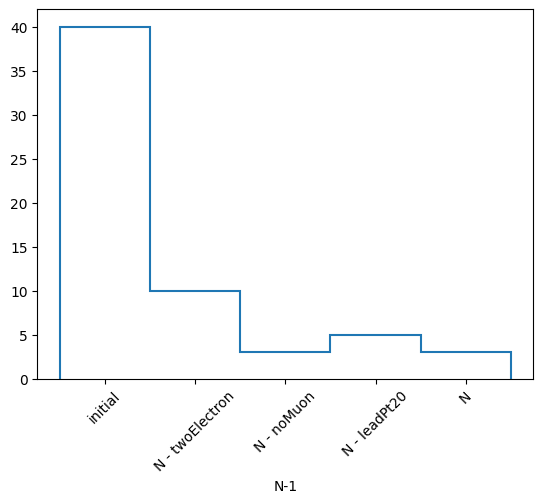

In [51]:
h.compute().plot1d()
plt.xticks(plt.gca().get_xticks(), labels, rotation=45)
plt.show()

And we got exactly the same thing. Saving to `.npz` files is still possible but the delayed arrays will be naturally materalized while saving.

In [52]:
nminusone.to_npz("nminusone_results.npz")

with np.load("nminusone_results.npz") as f:
    for i in f.files:
        print(f"{i}: {f[i]}")

labels: ['initial' 'N - twoElectron' 'N - noMuon' 'N - leadPt20' 'N']
nev: [40 10  3  5  3]
masks: [[False  True  True False False False False False False  True False False
  False False False  True  True False False False  True  True False False
  False False False  True False  True False False False  True False False
  False False False False]
 [False False  True False False False False False False False False False
  False False False False False False False False  True  True False False
  False False False False False False False False False False False False
  False False False False]
 [False False  True  True False False False False False False False False
  False False False False False False  True False  True  True False False
  False False False False False False False False False False False False
  False False False False]
 [False False  True False False False False False False False False False
  False False False False False False False False  True  True False False
  Fals

Same logic applies to the `plot_vars` function. Remember to use `dakevents` now and not `events`.

In [53]:
hs, labels = nminusone.plot_vars(
    {"Ept": dakevents.Electron.pt, "Ephi": dakevents.Electron.phi}
)

Those histograms are also delayed and have to be computed before plotting them.

Exactly the same things apply to the cutflow in delayed mode.